In [1]:
import sys 
assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)

In [165]:
from skimage.color import rgb2hsv
from skimage.morphology import closing, opening, disk, remove_small_holes, remove_small_objects, binary_dilation
from skimage.transform import rotate, resize
from sklearn.metrics.pairwise import euclidean_distances
from skimage.measure import regionprops
from skimage.measure import find_contours
from skimage.util import img_as_bool

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import Callable
from datetime import datetime

## Reference data

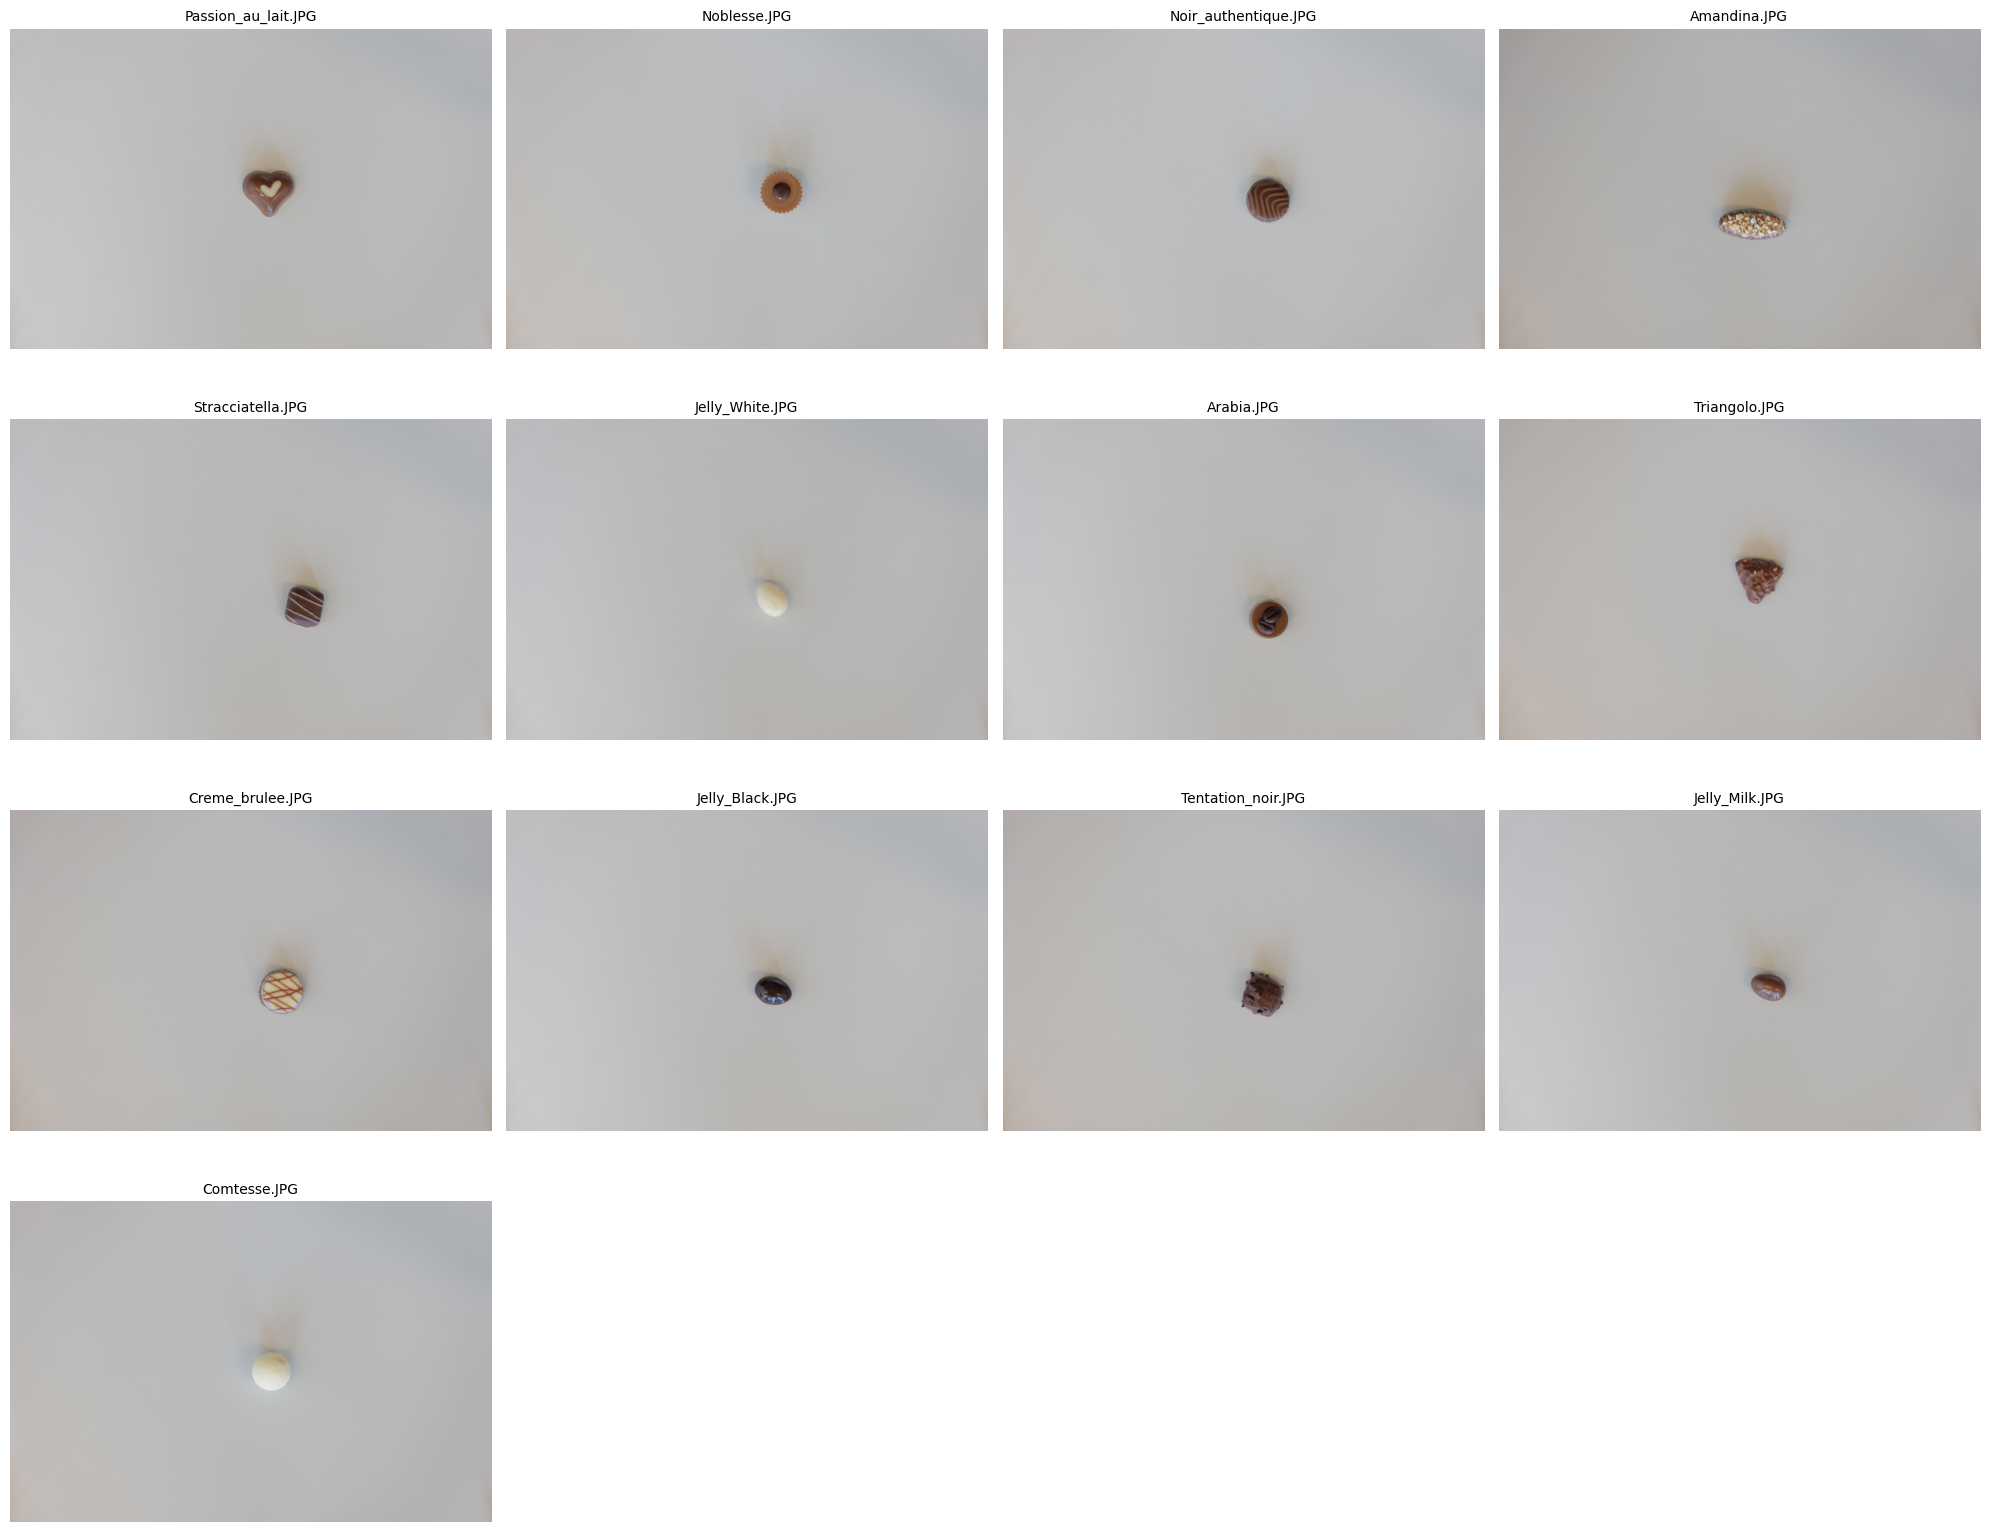

In [107]:
ref_dir = 'chocolate-recognition-classic/dataset_project_iapr2025/references/'
image_names = os.listdir(ref_dir)

cols = 4
rows = (len(image_names) + cols - 1) // cols 

rgb_images = []
grayscale_images = []

plt.figure(figsize=(20, 4 * rows))
for i, im in enumerate(image_names): 
    img = cv2.imread(os.path.join(ref_dir, im))
    img = cv2.resize(img, (img.shape[1] // 4, img.shape[0] // 4))

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    rgb_images.append(img_rgb)
    grayscale_images.append(gray)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(im, fontsize=10)

plt.tight_layout()

(1000, 1500, 3)


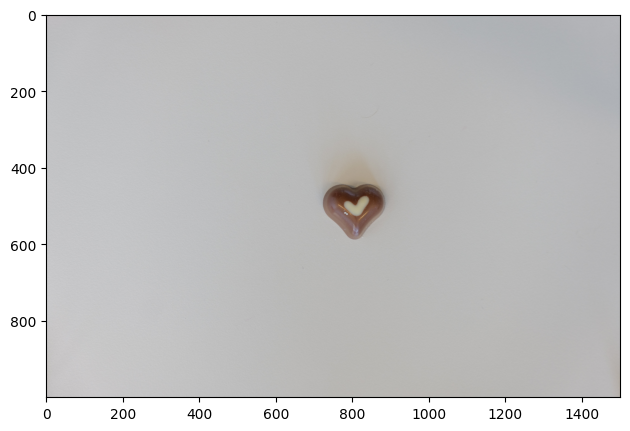

In [108]:
print(np.shape(rgb_images[0]))

plt.figure()
plt.imshow(rgb_images[0])
plt.tight_layout()

First, we will seperate the chocolates from the background by using object detection.

In [110]:
# Region growing

def region_growing(seeds: list[tuple], img: np.ndarray, n_max: int = 10, threshold: int = 20):

    M, N, _ = img.shape
    rg = np.zeros((M, N)).astype(bool)
    
    img_gray = img
    threshold = threshold

    if seeds is None:
        seeds = np.array([(i, j) for i in range(0, M, 50) for j in range(0, N, 50)])
    else:
        seeds = np.array(seeds)

    rg[seeds[:,0], seeds[:,1]] = True 

    for i in range(int(n_max)):
        
        mean_intensity = img_gray[rg].mean(axis=0) if rg.any() else 0
        rg_dilated = binary_dilation(rg) 
        new_pixels = rg_dilated & ~rg
        mask = np.linalg.norm(img_gray[new_pixels] - mean_intensity, axis=1) <= threshold
       
        if not np.any(mask): 
            break

        rg[new_pixels] = mask 
                    
    return rg

def plot_region_growing(seeds: list[tuple], img: np.ndarray, func: Callable, iters: list[int], threshold: int = 20):

    n = len(iters) + 1
    n_rows = np.ceil(n // 2).astype(int)
    _, axes = plt.subplots(n_rows, 2, figsize=(16, 6*n_rows))
    axes = axes.ravel()
    [a.axis('off') for a in axes]   

    axes[0].imshow(img)
    axes[0].set_title("Input image")

    for i, it in enumerate(iters):
        t1 = datetime.now()
        img_rg = func(seeds=seeds, img=img, n_max=iters[i], threshold=threshold)
        t2 = datetime.now()
        seconds = (t2 - t1).total_seconds()
        axes[i+1].imshow(img_rg)
        axes[i+1].set_title("RG {} iter in {:.2f} seconds".format(iters[i], seconds))
                            
    plt.tight_layout()
    return img_rg

array([[ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

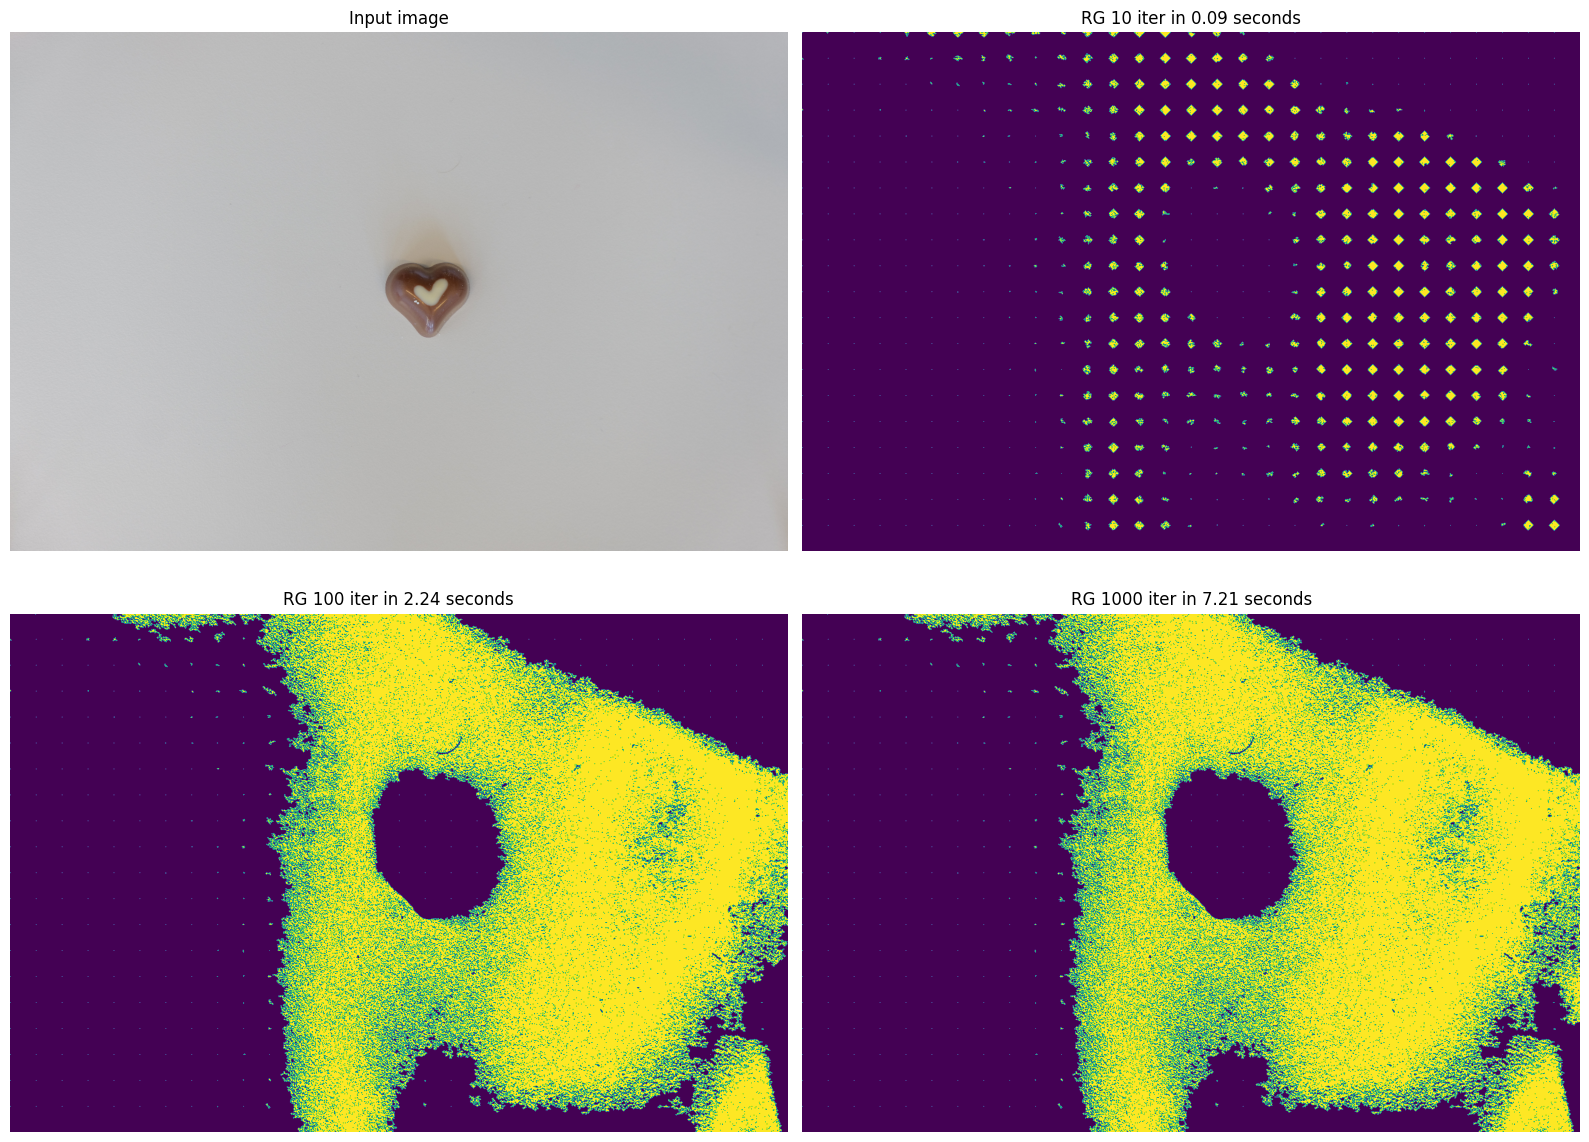

In [111]:
plot_region_growing(seeds=None, img=rgb_images[0], func=region_growing, iters=[10, 100, 1000], threshold=5)

Histograms for object identification?

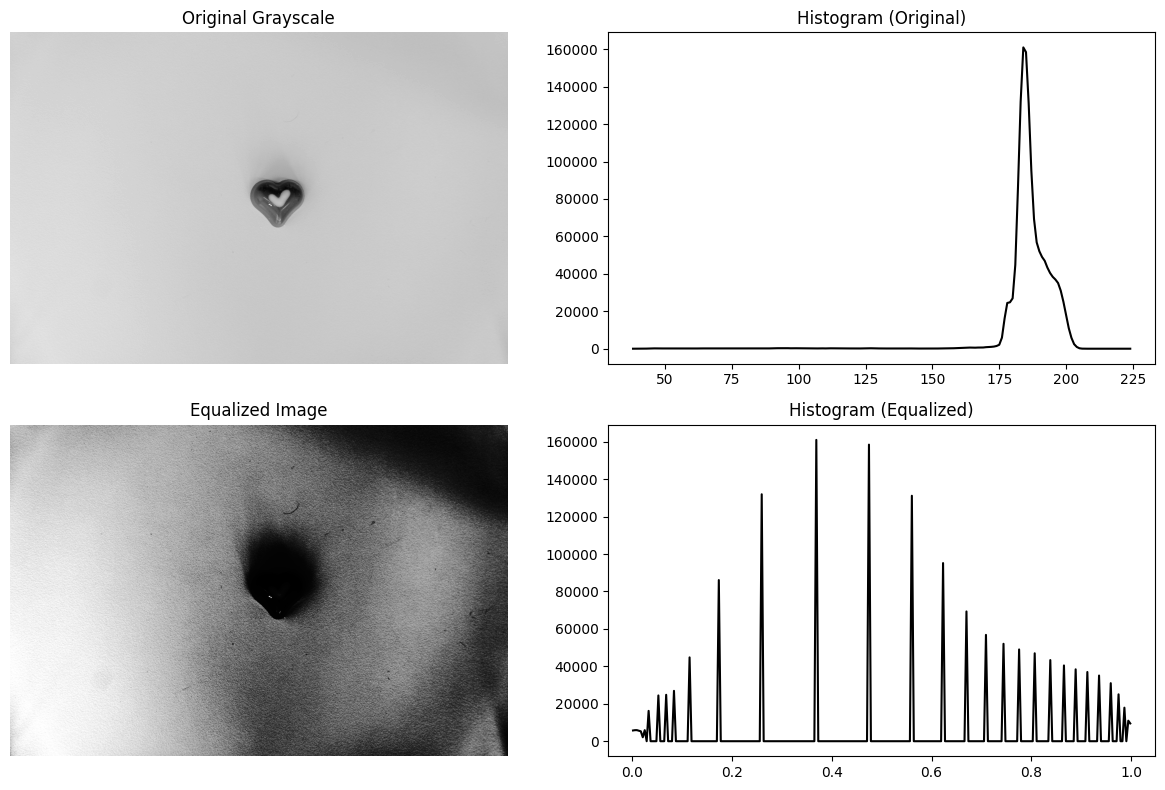

In [109]:
from skimage.exposure import histogram, equalize_hist, equalize_adapthist, adjust_gamma
from skimage.color import rgb2gray

img_gray = grayscale_images[0]

hist_orig, bins_orig = histogram(img_gray)

img_eq = equalize_hist(img_gray) 
hist_eq, bins_eq = histogram(img_eq)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].imshow(img_gray, cmap='gray')
axs[0, 0].set_title("Original Grayscale")
axs[0, 0].axis('off')

axs[0, 1].plot(bins_orig, hist_orig, color='black')
axs[0, 1].set_title("Histogram (Original)")

axs[1, 0].imshow(img_eq, cmap='gray')
axs[1, 0].set_title("Equalized Image")
axs[1, 0].axis('off')

axs[1, 1].plot(bins_eq, hist_eq, color='black')
axs[1, 1].set_title("Histogram (Equalized)")

plt.tight_layout()

Let's try contour detection.

(np.float64(-0.5), np.float64(1499.5), np.float64(999.5), np.float64(-0.5))

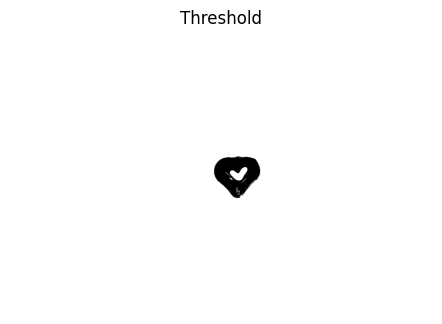

In [153]:
gray = grayscale_images[0]
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Threshold")
plt.imshow(thresh, cmap='gray')
plt.axis('off')

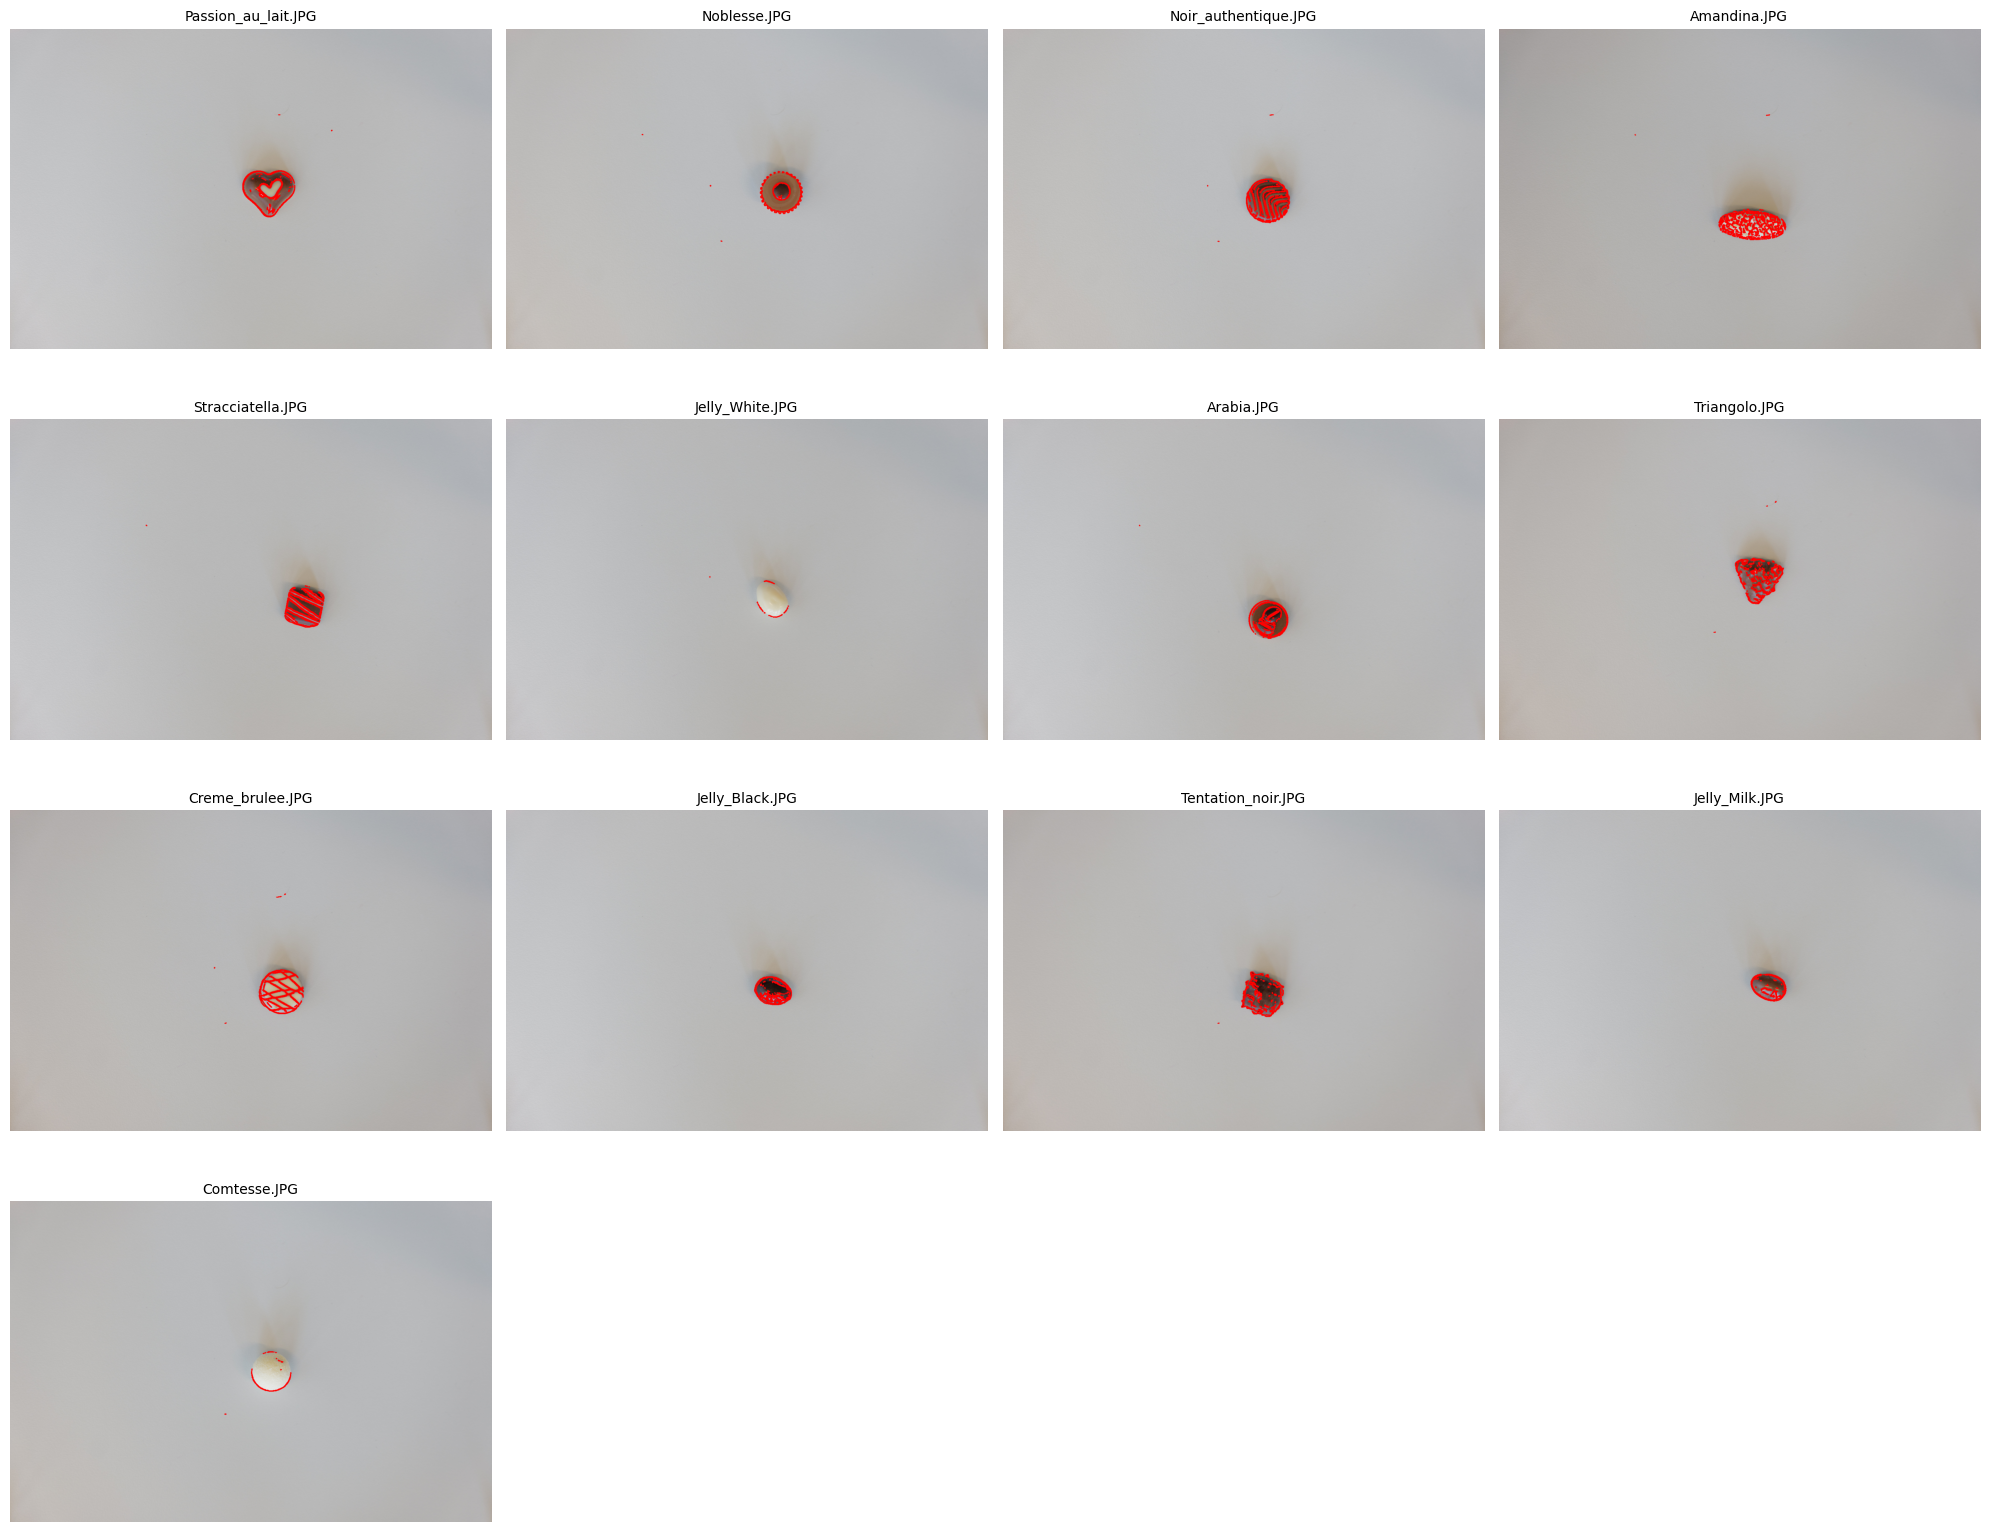

In [ ]:
plt.figure(figsize=(20, 4 * rows))

for i, gray in enumerate(grayscale_images):

    ## Thresholding
    _, thresh = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY_INV)
    thresh = cv2.adaptiveThreshold(
    gray, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # or ADAPTIVE_THRESH_MEAN_C
    cv2.THRESH_BINARY_INV,
    blockSize=17,  
    C=7
    )

    ## Morphological operations
    binary = img_as_bool(thresh)
    cleaned = remove_small_objects(binary, min_size=5)
    #cleaned = remove_small_holes(cleaned, area_threshold=1000) 
    processed = (cleaned * 255).astype(np.uint8)

    ## Find contours and draw them
    contours, _ = cv2.findContours(processed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # or use cv2.RETR_LIST or cv2.RETR_EXTERNAL

    img_copy = rgb_images[i].copy()
    cv2.drawContours(img_copy, contours, -1, (255, 0, 0), 2)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_copy)
    plt.axis('off')
    plt.title(image_names[i], fontsize=10)

plt.tight_layout()

Ideas/notes:
- For chocolates with particular patterns, we can use the pattern as a reference. This can be done using contours.
- For chocolates with no particular patterns, we can use the color of the chocolate as a reference.

For example, jelly blacks, jelly whites and jelly milks have the same shape but not the same colors.
And noir authentique and creme brulee have roughly same shapes but not the same patterns or colors.

Since for patterns contours work well, we can use distance maps or fourier descriptors.

Other ideas:
- Use contours to find chocolates and objects
- Bring each detected object to its own image (seperate it)
- Then compare to each reference image (classification)
    -> can do multiple ways at same time (minimize color difference and shape difference for example)
    -> which is why for now I need to first get a reference set, with different features to be able to compare to train set
- Can modify contour per chcolate? But needs to work in real cases..